# Stage 10a — Linear Regression (ASML)
Baseline linear model, residual diagnostics (linearity, independence, homoscedasticity, normality), R² & RMSE, and a simple feature transform.
_Chain:_ Fit baseline → check assumptions via residuals → add one targeted transform → compare.


Imports, paths, helpers

In [1]:
from __future__ import annotations
import sys
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from dotenv import load_dotenv

# Resolve project root when running from project/notebooks
project_root = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd().resolve()
sys.path.append(str(project_root / "src"))

load_dotenv(project_root / ".env")

from storage import env_paths, read_df, write_df

RAW_DIR, PROC_DIR = env_paths(project_root)
MODEL_DIR = PROC_DIR / "modeling"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

def stamp(): return datetime.now().strftime("%Y%m%d-%H%M")
def rmse(y_true, y_pred): return float(np.sqrt(mean_squared_error(y_true, y_pred)))


Load dataset (prefer engineered features)

In [2]:
# Prefer engineered features from Stage 09; else fall back to cleaned; else raw
feat_candidates  = sorted(PROC_DIR.glob("asml_features_*.parquet")) + sorted(PROC_DIR.glob("asml_features_*.csv"))
clean_candidates = sorted(PROC_DIR.glob("asml_cleaned_*.parquet")) + sorted(PROC_DIR.glob("asml_cleaned_*.csv"))
raw_candidates   = sorted(RAW_DIR.glob("api_*ASML_*.csv"))

if feat_candidates:
    path = feat_candidates[-1]
    print("Using FEATURES:", path.name)
    df = read_df(path, parse_dates=["date"])
elif clean_candidates:
    path = clean_candidates[-1]
    print("Using CLEANED:", path.name)
    df = read_df(path, parse_dates=["date"])
else:
    path = raw_candidates[-1]
    print("Using RAW:", path.name)
    df = read_df(path, parse_dates=["date"])

df = df.sort_values("date").reset_index(drop=True)

# Ensure a regression target exists (next-day return)
price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"
if "y_next_ret" not in df.columns:
    ret_today = df[price_col].pct_change()
    df["y_next_ret"] = ret_today.shift(-1)

print(df[["date", price_col, "y_next_ret"]].head(10))


Using FEATURES: asml_features_20250821-1006.csv
        date  adjusted_close  y_next_ret
0 2020-08-17      364.919250   -0.003408
1 2020-08-18      363.675568   -0.006044
2 2020-08-19      361.477417   -0.007388
3 2020-08-20      358.806976   -0.000135
4 2020-08-21      358.758667    0.015775
5 2020-08-24      364.417908    0.007513
6 2020-08-25      367.155945    0.013366
7 2020-08-26      372.063202   -0.025135
8 2020-08-27      362.711517    0.008638
9 2020-08-28      365.844788   -0.013941


Feature set (X) and target (y)

In [3]:
# Candidate features (only those that exist will be used)
candidate_cols = [
    "mom_5","mom_21","rsi_14",
    "vol_21","range_21",
    "ret","ret_lag1","ret_x_vol21",
    "ma_5","ma_21","month","is_month_end","is_quarter_end",
] + [c for c in df.columns if c.startswith("dow_")]  # include DOW one-hots if present

# Keep only present columns; drop obvious leaks/identifiers
X_cols = [c for c in candidate_cols if c in df.columns]
drop_cols = {"date","y_next_up","y_next_ret"}  # y_next_ret is the target, don't include in X
X_cols = [c for c in X_cols if c not in drop_cols]

y = df["y_next_ret"]
X = df[X_cols].copy()

# Remove rows with any NaNs in X or y
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

print("X shape:", X.shape, "y shape:", y.shape)
print("Features used:", X.columns.tolist()[:12], "... (total:", len(X.columns), ")")


X shape: (1234, 18) y shape: (1234,)
Features used: ['mom_5', 'mom_21', 'rsi_14', 'vol_21', 'range_21', 'ret', 'ret_lag1', 'ret_x_vol21', 'ma_5', 'ma_21', 'month', 'is_month_end'] ... (total: 18 )


Time-based train/test split (80/20), pipeline, fit

In [4]:
n = len(X)
split = int(n * 0.80)  # first 80% train, last 20% test (respects time order)

X_train, X_test = X.iloc[:split, :], X.iloc[split:, :]
y_train, y_test = y.iloc[:split], y.iloc[split:]

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

pipe.fit(X_train, y_train)

yhat_train = pipe.predict(X_train)
yhat_test  = pipe.predict(X_test)

metrics = {
    "r2_train": r2_score(y_train, yhat_train),
    "r2_test":  r2_score(y_test,  yhat_test),
    "rmse_train": rmse(y_train, yhat_train),
    "rmse_test":  rmse(y_test,  yhat_test),
}
metrics


{'r2_train': 0.013482485687856371,
 'r2_test': 0.008560342200336857,
 'rmse_train': 0.025600323492960222,
 'rmse_test': 0.02717785491415839}

Residuals & diagnostics (baseline)

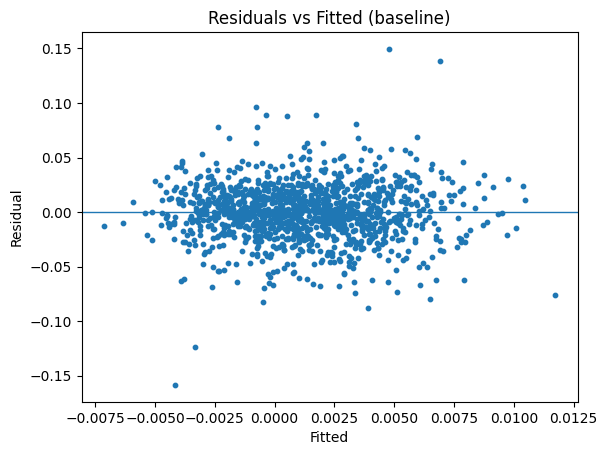

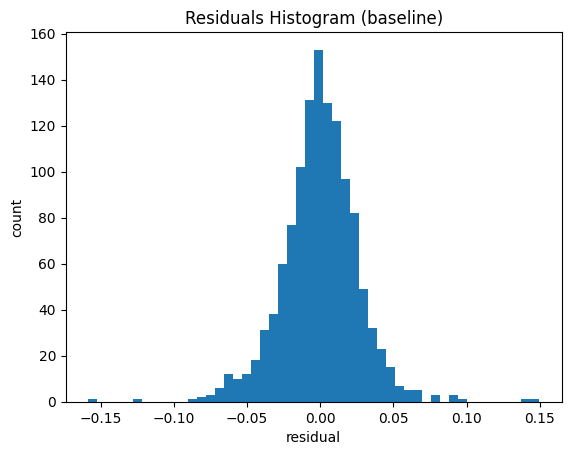

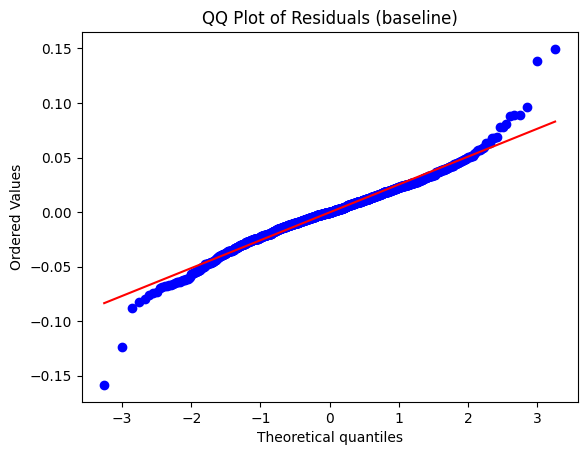

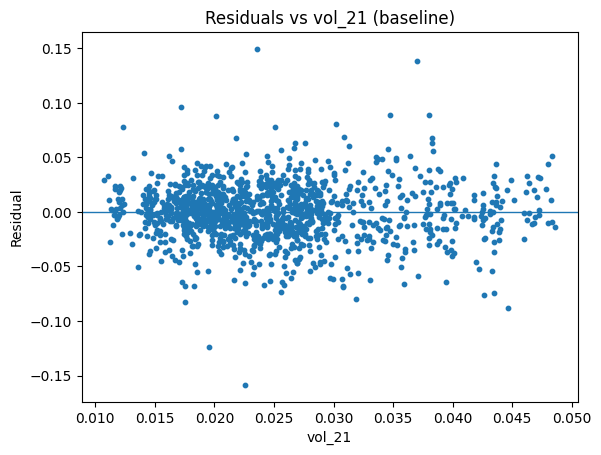

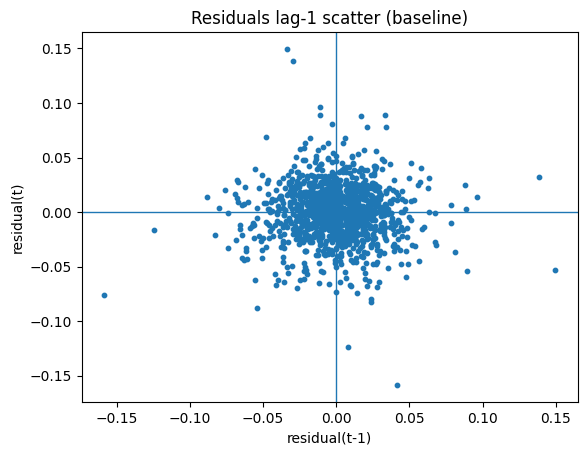

In [5]:
# Residuals
res_train = y_train - yhat_train
res_test  = y_test  - yhat_test
res_all   = pd.concat([res_train, res_test], ignore_index=True)
fit_all   = pd.concat([pd.Series(yhat_train, index=y_train.index),
                       pd.Series(yhat_test,  index=y_test.index)]).reset_index(drop=True)

# 1) Residuals vs fitted
plt.figure()
plt.scatter(fit_all, res_all, s=10)
plt.axhline(0, lw=1)
plt.title("Residuals vs Fitted (baseline)")
plt.xlabel("Fitted"); plt.ylabel("Residual")
plt.show()

# 2) Residual histogram
plt.figure()
plt.hist(res_all, bins=50)
plt.title("Residuals Histogram (baseline)")
plt.xlabel("residual"); plt.ylabel("count")
plt.show()

# 3) QQ plot for normality
plt.figure()
stats.probplot(res_all, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (baseline)")
plt.show()

# 4) Residual vs key predictor (vol_21 if present)
key = "vol_21" if "vol_21" in X.columns else X.columns[0]
plt.figure()
plt.scatter(X[key].reset_index(drop=True), res_all, s=10)
plt.axhline(0, lw=1)
plt.title(f"Residuals vs {key} (baseline)")
plt.xlabel(key); plt.ylabel("Residual")
plt.show()

# 5) Residual lag-1 (independence check)
res_lag1 = res_all.shift(1)
mask = res_lag1.notna()
plt.figure()
plt.scatter(res_lag1[mask], res_all[mask], s=10)
plt.axhline(0, lw=1); plt.axvline(0, lw=1)
plt.title("Residuals lag-1 scatter (baseline)")
plt.xlabel("residual(t-1)"); plt.ylabel("residual(t)")
plt.show()


Add a transformed feature (still linear in β)

In [6]:
# Add a polynomial term: mom_21^2 if mom_21 exists; else rsi_14^2; else skip
X2 = X.copy()
added_term = None
if "mom_21" in X2.columns:
    X2["mom_21_sq"] = X2["mom_21"] ** 2
    added_term = "mom_21_sq"
elif "rsi_14" in X2.columns:
    X2["rsi_14_sq"] = X2["rsi_14"] ** 2
    added_term = "rsi_14_sq"

if added_term:
    # Keep same time split
    X2_train, X2_test = X2.iloc[:split, :], X2.iloc[split:, :]
    pipe2 = Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())])
    pipe2.fit(X2_train, y_train)
    y2_tr = pipe2.predict(X2_train); y2_te = pipe2.predict(X2_test)

    metrics2 = {
        "r2_train": r2_score(y_train, y2_tr),
        "r2_test":  r2_score(y_test,  y2_te),
        "rmse_train": rmse(y_train, y2_tr),
        "rmse_test":  rmse(y_test,  y2_te),
        "added_term": added_term
    }
else:
    metrics2 = {"note": "No candidate column available for squared term."}

metrics2


{'r2_train': 0.014848422177606846,
 'r2_test': 0.013374336056565461,
 'rmse_train': 0.025582594193559176,
 'rmse_test': 0.027111792784008392,
 'added_term': 'mom_21_sq'}

Compare metrics table & coefficient inspection

In [7]:
tbl = pd.DataFrame([metrics, metrics2]).T
tbl.columns = ["baseline", "with_transform"]
tbl

,baseline,with_transform
r2_train,0.013482,0.014848
r2_test,0.00856,0.013374
rmse_train,0.0256,0.025583
rmse_test,0.027178,0.027112
added_term,NaN,mom_21_sq


In [9]:
try:
    # Recover feature names passing through scaler unchanged
    feat_names = X.columns if "with_transform" not in tbl.columns else X2.columns
    reg = pipe.named_steps["model"]
    coefs = pd.Series(reg.coef_, index=X.columns, name="coef").sort_values(key=np.abs, ascending=False)
    coefs.head(15)
except Exception as e:
    print("Coeff view skipped:", e)

Save artifacts (metrics, residuals)

In [10]:
metrics_path = MODEL_DIR / f"linear_metrics_{stamp()}.csv"
tbl.to_csv(metrics_path)

residuals_df = pd.DataFrame({"fitted": fit_all, "residual": res_all})
residuals_path = MODEL_DIR / f"linear_residuals_{stamp()}.csv"
residuals_df.to_csv(residuals_path, index=False)

metrics_path, residuals_path

(WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/modeling/linear_metrics_20250822-0927.csv'),
 WindowsPath('C:/Users/melin/OneDrive/Desktop/nyu/python/bootcamp_panagiotis_housos/project/data/processed/modeling/linear_residuals_20250822-0927.csv'))